# Liver Model

## Import some things

In [1]:
import os, sys
sys.path.append('..')
from Base_Deeplearning_Code.Data_Generators.Generators import Data_Generator_Class, os
from Base_Deeplearning_Code.Keras_Utils.Keras_Utilities import np, dice_coef_3D
from Base_Deeplearning_Code.Plot_And_Scroll_Images.Plot_Scroll_Images import plot_scroll_Image
from Base_Deeplearning_Code.Data_Generators.Image_Processors import *
from Base_Deeplearning_Code.Callbacks.Visualizing_Model_Utils import TensorBoardImage
from Utils import ModelCheckpoint, model_path_maker
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.
c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

In [2]:
%matplotlib inline

In [3]:
%load_ext tensorboard

In [4]:
base = '.'
for i in range(3):
    if 'Data' not in os.listdir(base):
        base = os.path.join(base,'..')
    else:
        break

In [5]:
data_path = os.path.join(base,'Data','Niftii_Arrays')
train_path = [os.path.join(data_path,'Train')]
validation_path = os.path.join(data_path,'Validation')
test_path = os.path.join(data_path,'Test')
model_path = os.path.join(base,'Models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

## We now need some image processors...

#### We will ensure that the images are 256 x 256 (downsampled for speed), normalize them with a mean of 78 and std of 29, add random noise, threshold, and turn into 2 classes

In [30]:
image_size = 256
image_processors_train = [Ensure_Image_Proportions(image_size,image_size),Repeat_Channel(repeats=3),
                          Normalize_Images(mean_val=78,std_val=29, post_load=False),
                          Threshold_Images(lower_bound=-3.55,upper_bound=3.55),
                          Annotations_To_Categorical(2)]
#Add_Noise_To_Images(variation=np.round(np.arange(start=0, stop=0.3, step=0.1),2)),
image_processors_test = [Ensure_Image_Proportions(image_size,image_size),Normalize_Images(mean_val=78,std_val=29),
                         Repeat_Channel(repeats=3), Threshold_Images(lower_bound=-3.55,upper_bound=3.55),
                         Annotations_To_Categorical(2)]

In [31]:
batch_size = 5
train_generator = Data_Generator_Class(shuffle=True,data_paths=train_path,batch_size=batch_size,
                                       image_processors=image_processors_train)
validation_generator = Data_Generator_Class(by_patient=True,shuffle=True,data_paths=validation_path,batch_size=30,
                                            image_processors=image_processors_test, by_patient_2D=True)

### Lets visualize one of the examples! With batch_size of 5 and shuffle on, it will be 5 random 2D slices

In [8]:
x,y = train_generator.__getitem__(0)

(<Figure size 432x288 with 1 Axes>,
 <Plot_And_Scroll_Images.Plot_Scroll_Images.IndexTracker at 0x248035b5780>)

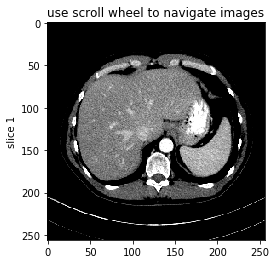

In [9]:
plot_scroll_Image(x[4,...])

### Alright, lets make our model!

In [ ]:
from Easy_VGG16_UNet.Keras_Fine_Tune_VGG_16_Liver import VGG_16
from Base_Deeplearning_Code.Visualizing_Model.Visualing_Model import visualization_model_class
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K

### This is just a click and play, it builds the VGG16 architecture for you with pre-trained weights

![VGG16_Unet.png](./VGG16_UNet.png)

In [ ]:
K.clear_session()
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
K.set_session(sess)
network = {'Layer_0': {'Encoding': [64, 64], 'Decoding': [64]},
           'Layer_1': {'Encoding': [128, 128], 'Decoding': [64]},
           'Layer_2': {'Encoding': [256, 256, 256], 'Decoding': [256]},
           'Layer_3': {'Encoding': [512, 512, 512], 'Decoding': [256]},
           'Layer_4': {'Encoding': [512, 512, 512]}}
VGG_model = VGG_16(network=network, activation='relu',filter_size=(3,3))
VGG_model.make_model()
VGG_model.load_weights()
new_model = VGG_model.created_model
model_path = os.path.join('..','Models')

## These are some tools for visualizing the model

In [ ]:
Visualizing_Class = visualization_model_class(model=new_model, save_images=True, verbose=True)

### Lets look at the activations of block1_conv1, the activation, and output

In [ ]:
Visualizing_Class.define_desired_layers(['block1_conv1','block1_conv1_activation','Output'])

In [ ]:
Visualizing_Class.predict_on_tensor(x[0,...][None,...])

In [ ]:
Visualizing_Class.plot_activations()

In [ ]:
new_model.compile(Adam(lr=5e-5),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

## Freezing pre-trained layers

In [ ]:
def freeze_until_name(model,name):
    set_trainable = False
    for layer in model.layers:
        if layer.name == name:
            set_trainable = True
        layer.trainable = set_trainable
    return model
new_model = freeze_until_name(new_model,'Upsampling0_UNet')

## Checkpoint and run

A checkpoint is a way of assessing the model and determining if we should save it

In [ ]:
model_name = 'VGG_16_Model'
other_aspects = [model_name,'Upsampling0_UNet_Unfrozen'] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'best-model.hdf5'), monitor='val_dice_coef_3D', verbose=1, save_best_only=True,
                              save_weights_only=False, period=5, mode='max')
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=model_path_out, batch_size=1, num_images=3,update_freq='epoch', 
                               data_generator=validation_generator)
callbacks = [checkpoint, tensorboard]

In [ ]:
%tensorboard --logdir {"../Models"}

In [ ]:
#new_model.fit_generator(train_generator,epochs=1, workers=20, max_queue_size=50, validation_data=validation_generator,callbacks=callbacks)

In [ ]:
x,y = validation_generator.__getitem__(0)

In [ ]:
pred = new_model.predict(x)

In [ ]:
pred[pred<0.5] = 0
pred[pred>0] = 1

In [ ]:
plot_scroll_Image(pred[...,1])

# Now lets make our own architecture

### First, lets import some necessary functions

In [11]:
from Base_Deeplearning_Code.Models.Keras_3D_Models import my_3D_UNet
from Base_Deeplearning_Code.Cyclical_Learning_Rate.clr_callback import CyclicLR
from functools import partial
from keras.optimizers import Adam

### Define our convolution and strided blocks, strided is used for downsampling

In [12]:
activation = 'relu'
kernel = (3,3)
pool_size = (2,2)

conv_block = lambda x: {'channels': x}
strided_block = lambda x: {'channels': x, 'strides': (2, 2)}

### Our architecture will have 2 main parts in each layer, an 'Encoding' and a 'Decoding' side, 'Encoding' goes down, and 'Decoding' goes up

![Encoding and Decoding.png](./Encoding_and_Decoding.png)

### We will now create our layer dictionary, this tells our UNet what to look like

### If Pooling is left {} it will perform maxpooling and upsampling with pooling()

In [32]:
layers_dict = {}
filters = 16
layers_dict['Layer_0'] = {'Encoding':[conv_block(filters),conv_block(filters), conv_block(filters)],
                          'Decoding':[conv_block(filters),conv_block(filters)],
                          'Pooling':{}}
filters = 32
layers_dict['Base'] = {'Encoding':[conv_block(filters), conv_block(filters),conv_block(filters)]}

In [33]:
layers_dict

{'Layer_0': {'Encoding': [{'channels': 16}, {'channels': 16}],
  'Decoding': [{'channels': 16}, {'channels': 16}],
  'Pooling': {}},
 'Layer_1': {'Encoding': [{'channels': 32}, {'channels': 32}],
  'Decoding': [{'channels': 32}, {'channels': 32}],
  'Pooling': {}},
 'Base': {'Encoding': [{'channels': 64}, {'channels': 64}]}}

In [34]:
K.clear_session()
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
K.set_session(sess)
new_model = my_3D_UNet(kernel=kernel,layers_dict=layers_dict, pool_size=pool_size,activation=activation,is_2D=True,
                       input_size=3, image_size=image_size).created_model

Layer_0
Layer_1
Base
Layer_1
Layer_0


### Set a learning rate and loss metric, also add any metrics you want to track

In [35]:
min_lr = 5e-6
max_lr = 8e-4
new_model.compile(Adam(lr=min_lr),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

### Name your model and define other things! Send a list of strings and it will make a folder path

In [36]:
model_name = 'My_New_Model'
other_aspects = [model_name,'{}_Layers'.format(3),'{}_Conv_Blocks'.format(2),
                 '{}_Filters'.format(16),'{}_MinLR_{}_MaxLR'.format(min_lr,max_lr)] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

### A few more parameters...

In [38]:
steps_per_epoch = len(train_generator)//3
step_size_factor = 2

### This is a checkpoint to save the model if it has the highest dice, also to add images

In [39]:
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'best-model.hdf5'), monitor='val_dice_coef_3D', verbose=1, save_best_only=True,
                              save_weights_only=False, period=5, mode='max')
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=model_path_out, batch_size=1, num_images=1,update_freq='epoch', 
                               data_generator=validation_generator, image_frequency=3)
lrate = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=steps_per_epoch * step_size_factor, mode='triangular2')
callbacks = [lrate, checkpoint, tensorboard]

In [40]:
new_model.fit_generator(train_generator,epochs=10, workers=50, max_queue_size=200, validation_data=validation_generator,
                       callbacks=callbacks, steps_per_epoch=steps_per_epoch)

Epoch 1/10


c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 215 could not be retrieved. It could be because a worker has died.
  UserWarning)


KeyboardInterrupt: 

In [29]:
%tensorboard --logdir {"../Models"}

Reusing TensorBoard on port 6006 (pid 3716), started 0:01:09 ago. (Use '!kill 3716' to kill it.)